# Modelo Solución Final - Pruebas Saber Pro Colombia

- Preprocesamiento completo de datos categóricos y numéricos
- Codificación ordinal para variables con orden natural
- One-hot encoding para variables categóricas
- Gradient Boosting como modelo final


In [ ]:
# Importaciones y configuración
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento
import unidecode as ud
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Modelos
from sklearn.ensemble import GradientBoostingClassifier

# Configuración
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

print("Librerías cargadas")

Librerías cargadas


### Descarga de Datos de Kaggle

Descargamos automáticamente los datos de la competencia desde Kaggle y los descomprimimos.

In [ ]:
import os
import shutil

os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)


## Configuración Inicial

In [ ]:
# Carga de datos
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Entrenamiento: {df_train.shape}")
print(f"Prueba: {df_test.shape}")
print(f"Valores nulos en entrenamiento: {df_train.isnull().sum().sum()}")
print(f"Variable objetivo: {df_train['RENDIMIENTO_GLOBAL'].value_counts().sort_index()}")

Entrenamiento: (692500, 21)
Prueba: (296786, 20)
Valores nulos en entrenamiento: 297378
Variable objetivo: RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64


### Carga y Exploración Inicial

Cargamos los datasets de entrenamiento y prueba, y realizamos una primera exploración de sus dimensiones y contenido.

## Análisis Exploratorio de Datos

DISTRIBUCIÓN DE LA VARIABLE OBJETIVO
Clases: ['alto', 'bajo', 'medio-alto', 'medio-bajo']
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-alto    171619
medio-bajo    172275
Name: count, dtype: int64


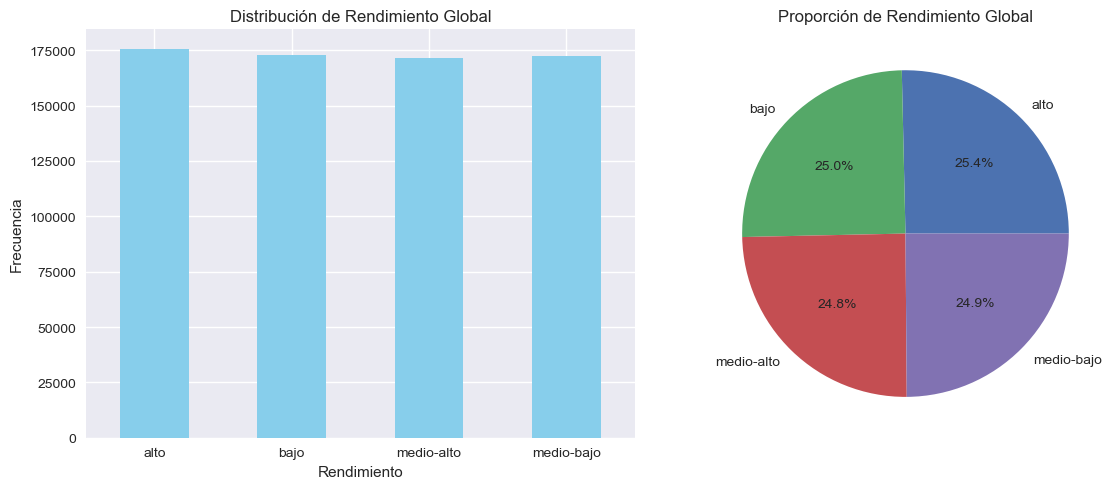

Balance de clases: 97.7%


In [ ]:
# Análisis de la variable objetivo
print("DISTRIBUCIÓN DE LA VARIABLE OBJETIVO")
print(f"Clases: {sorted(df_train['RENDIMIENTO_GLOBAL'].unique())}")
objetivo_counts = df_train['RENDIMIENTO_GLOBAL'].value_counts().sort_index()
print(objetivo_counts)

# Visualización de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
objetivo_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Rendimiento Global')
axes[0].set_xlabel('Rendimiento')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=0)

# Gráfico de pastel
objetivo_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Proporción de Rendimiento Global')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Balance de clases
print(f"Balance de clases: {objetivo_counts.min() / objetivo_counts.max() * 100:.1f}%")

### Análisis de Variable Objetivo

Examinamos la distribución de la variable objetivo (RENDIMIENTO_GLOBAL) para entender el balance de clases y las proporciones de cada categoría de rendimiento.

INFORMACIÓN GENERAL DEL DATASET
Columnas: ['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']

Tipos de datos:
object     15
float64     4
int64       2
Name: count, dtype: int64

VALORES NULOS POR COLUMNA:
                                Total  Porcentaje
FAMI_TIENEAUTOMOVIL             43623    6.299350
FAMI_TIENELAVADORA              39773    5.743394
FAMI_TIENECOMPUTADOR            38103    5.502238
FAMI_ESTRATOVIVIENDA            32137    4.640722
ESTU_HORASSEMANATRABAJA         30857    4.455884
FAMI_TIENEINTERNET              26629    3.845343
FAMI_TIENEINTERNET.1            26629    3.845343
FAMI_EDUCACIONMAD

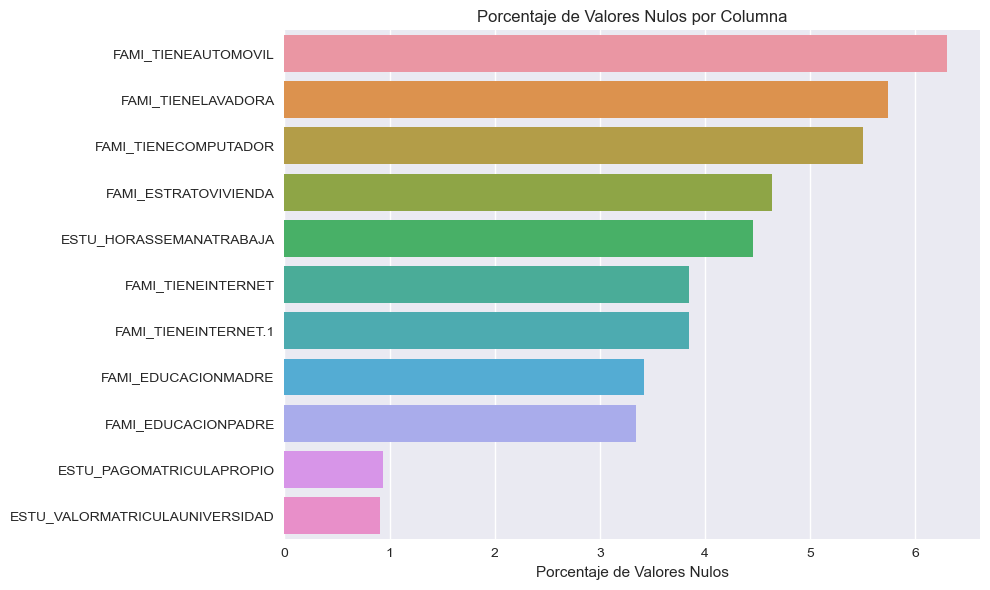

In [ ]:
# Análisis de valores nulos y tipos de datos
print("INFORMACIÓN GENERAL DEL DATASET")
print(f"Columnas: {list(df_train.columns)}")
print(f"\nTipos de datos:")
print(df_train.dtypes.value_counts())

print(f"\nVALORES NULOS POR COLUMNA:")
missing_data = df_train.isnull().sum().sort_values(ascending=False)
missing_percent = (df_train.isnull().sum() / len(df_train) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'Total': missing_data,
    'Porcentaje': missing_percent
})
print(missing_df[missing_df['Total'] > 0])

# Visualización de valores nulos
plt.figure(figsize=(10, 6))
cols_with_nulls = missing_df[missing_df['Total'] > 0].index
if len(cols_with_nulls) > 0:
    sns.barplot(x=missing_df.loc[cols_with_nulls, 'Porcentaje'],
                y=cols_with_nulls)
    plt.title('Porcentaje de Valores Nulos por Columna')
    plt.xlabel('Porcentaje de Valores Nulos')
    plt.tight_layout()
    plt.show()
else:
    print("No hay valores nulos para visualizar")

### Calidad de Datos y Valores Faltantes

Analizamos los tipos de datos y identificamos patrones de valores faltantes que necesitarán tratamiento en el preprocesamiento.

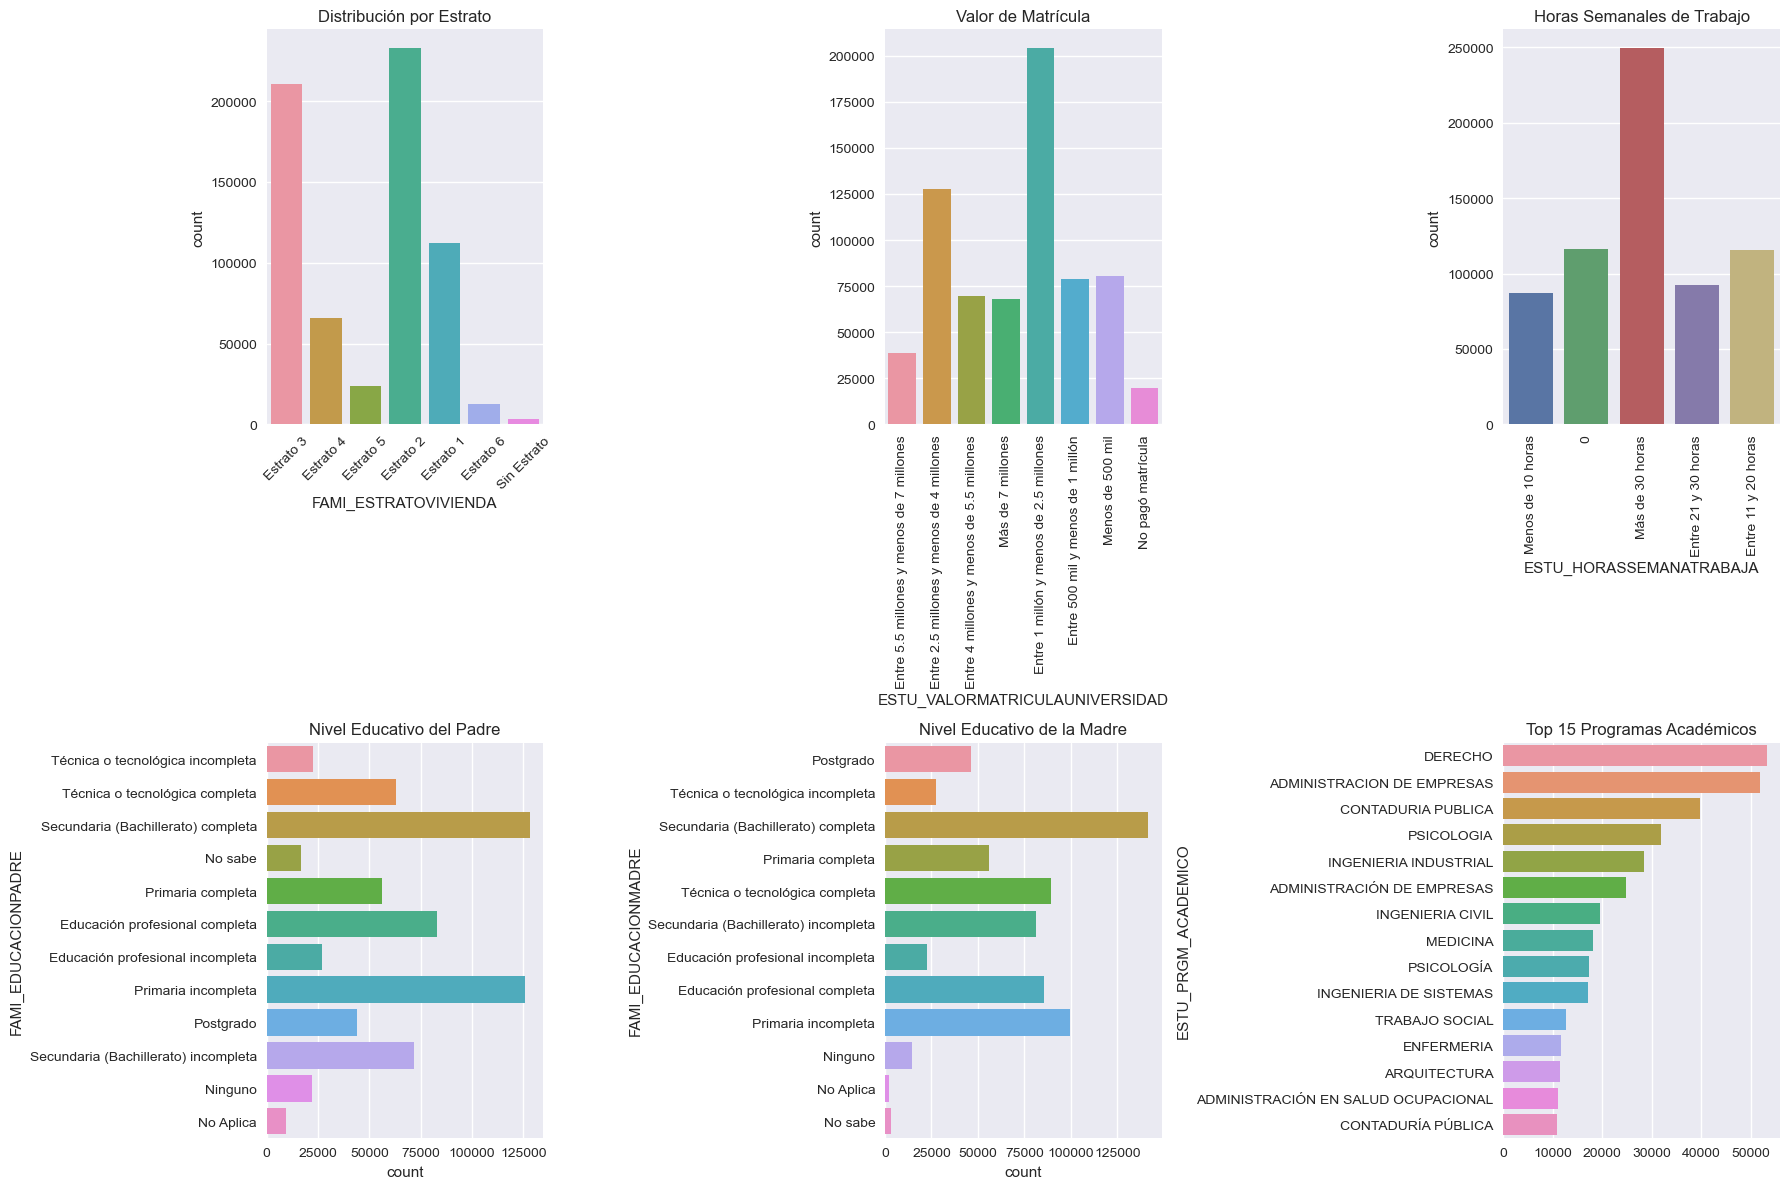

Programas académicos únicos: 948


In [ ]:
# Análisis de variables categóricas principales
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Estrato socioeconómico
sns.countplot(data=df_train, x='FAMI_ESTRATOVIVIENDA', ax=axes[0, 0])
axes[0, 0].set_title('Distribución por Estrato')
axes[0, 0].tick_params(axis='x', rotation=45)

# Valor de matrícula
sns.countplot(data=df_train, x='ESTU_VALORMATRICULAUNIVERSIDAD', ax=axes[0, 1])
axes[0, 1].set_title('Valor de Matrícula')
axes[0, 1].tick_params(axis='x', rotation=90)

# Horas de trabajo
sns.countplot(data=df_train, x='ESTU_HORASSEMANATRABAJA', ax=axes[0, 2])
axes[0, 2].set_title('Horas Semanales de Trabajo')
axes[0, 2].tick_params(axis='x', rotation=90)

# Educación del padre
sns.countplot(data=df_train, y='FAMI_EDUCACIONPADRE', ax=axes[1, 0])
axes[1, 0].set_title('Nivel Educativo del Padre')

# Educación de la madre
sns.countplot(data=df_train, y='FAMI_EDUCACIONMADRE', ax=axes[1, 1])
axes[1, 1].set_title('Nivel Educativo de la Madre')

# Top programas académicos
top_programs = df_train['ESTU_PRGM_ACADEMICO'].value_counts().head(15)
sns.barplot(x=top_programs.values, y=top_programs.index, ax=axes[1, 2])
axes[1, 2].set_title('Top 15 Programas Académicos')

plt.tight_layout()
plt.show()

print(f"Programas académicos únicos: {df_train['ESTU_PRGM_ACADEMICO'].nunique()}")

### Distribución de Variables Categóricas

Exploramos las principales variables categóricas del dataset para entender la composición socioeconómica y académica de los estudiantes.

ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS:
              coef_1         coef_2         coef_3         coef_4
count  692500.000000  692500.000000  692500.000000  692500.000000
mean        0.268629       0.259996       0.262087       0.262903
std         0.122130       0.093480       0.058862       0.067944
min         0.000000       0.000000       0.000000       0.000000
25%         0.203000       0.212000       0.254000       0.255000
50%         0.240000       0.271000       0.276000       0.285000
75%         0.314000       0.309000       0.293000       0.303000
max         0.657000       0.487000       0.320000       0.332000


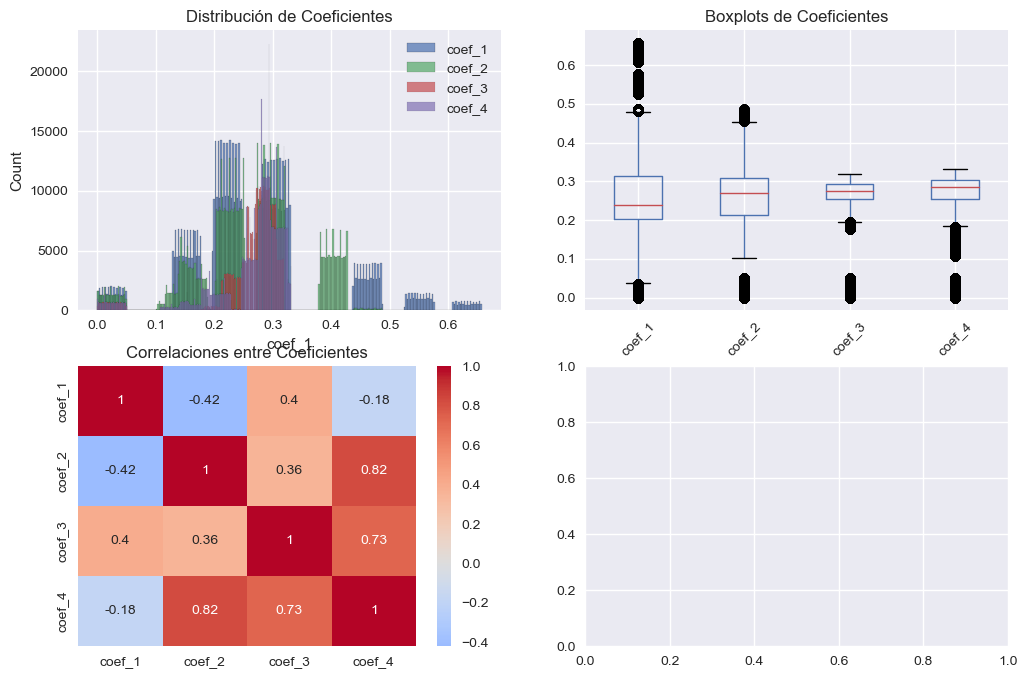

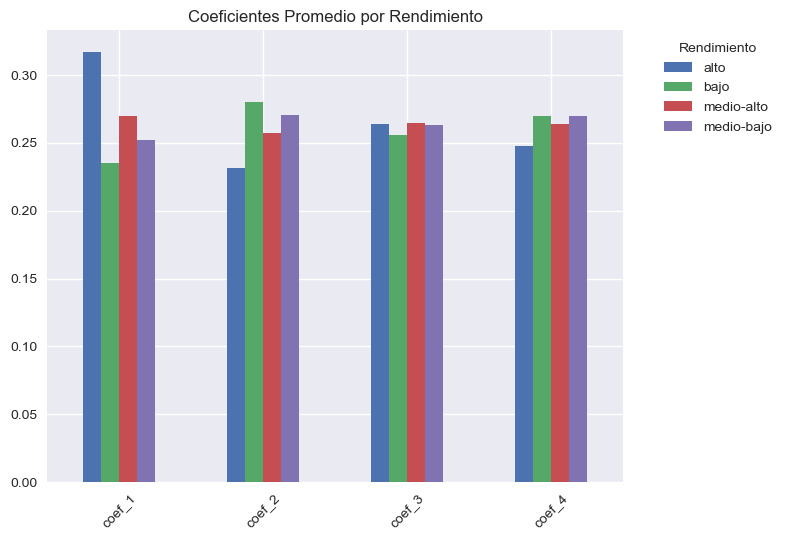

In [ ]:
# Análisis de variables numéricas
numeric_cols = ['coef_1', 'coef_2', 'coef_3', 'coef_4']
print("ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS:")
print(df_train[numeric_cols].describe())

# Distribución de coeficientes
plt.figure(figsize=(12, 8))

# Histogramas de coeficientes
plt.subplot(2, 2, 1)
for col in numeric_cols:
    sns.histplot(df_train[col], alpha=0.7, label=col)
plt.title('Distribución de Coeficientes')
plt.legend()

# Boxplots de coeficientes
plt.subplot(2, 2, 2)
df_train[numeric_cols].boxplot()
plt.title('Boxplots de Coeficientes')
plt.xticks(rotation=45)

# Correlaciones entre coeficientes
plt.subplot(2, 2, 3)
correlation_matrix = df_train[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlaciones entre Coeficientes')

# Relación coeficientes vs objetivo
plt.subplot(2, 2, 4)
coef_means = df_train.groupby('RENDIMIENTO_GLOBAL')[numeric_cols].mean()
coef_means.T.plot(kind='bar')
plt.title('Coeficientes Promedio por Rendimiento')
plt.xticks(rotation=45)
plt.legend(title='Rendimiento', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Análisis de Variables Numéricas

Examinamos las características numéricas (coeficientes) y sus correlaciones, así como su relación con la variable objetivo.

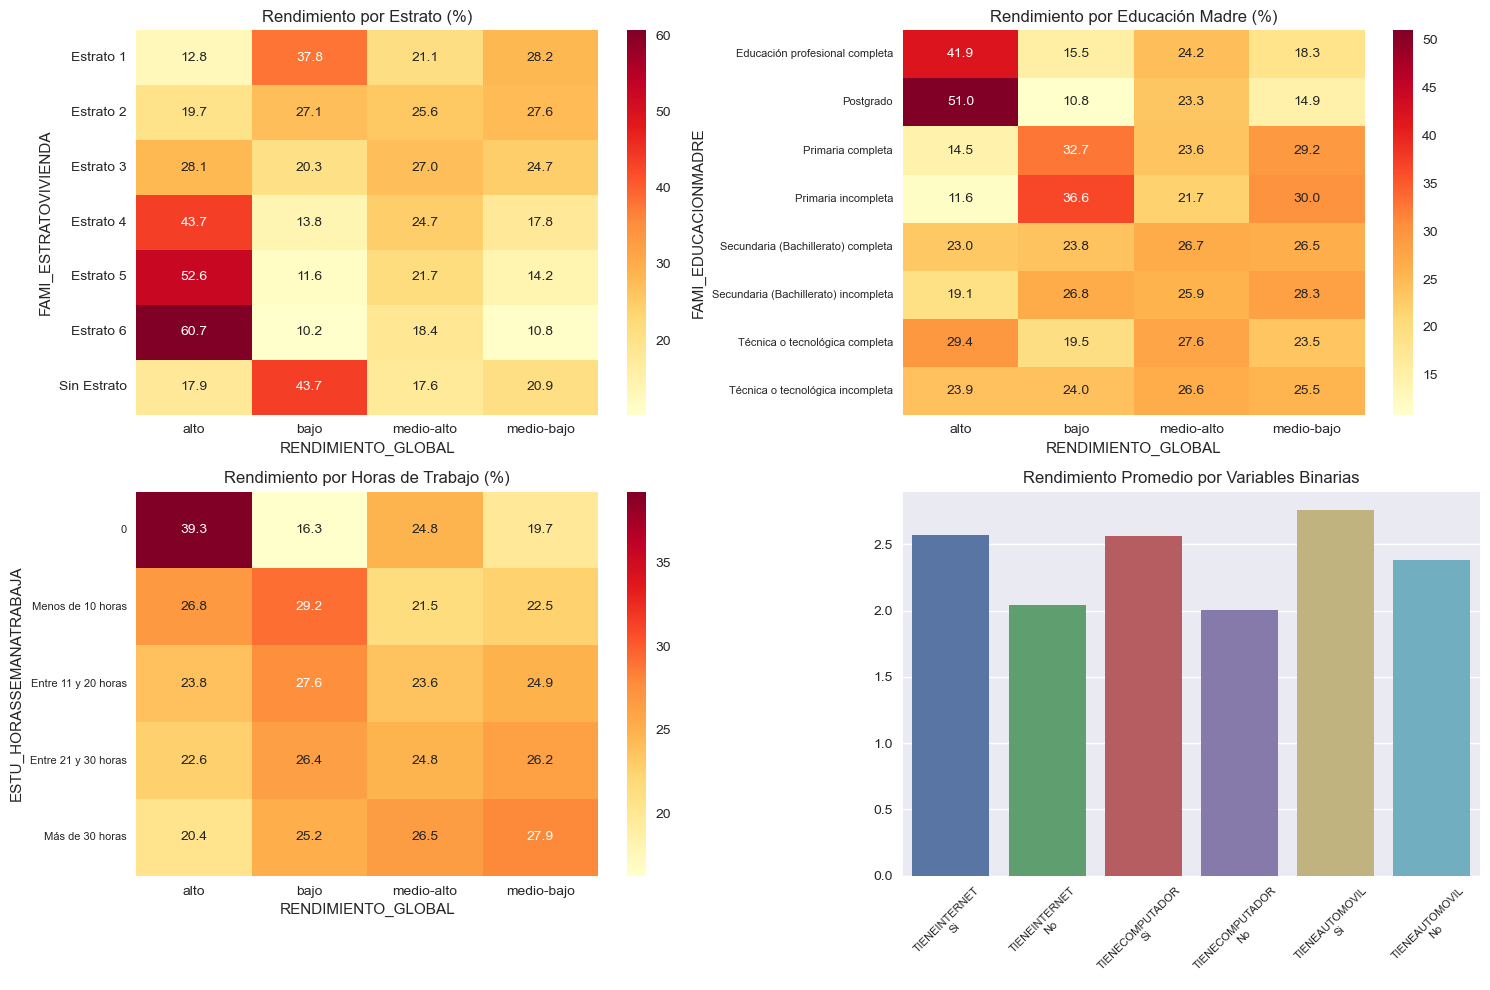

In [ ]:
# Relación entre variables categóricas y rendimiento
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rendimiento por estrato
crosstab_estrato = pd.crosstab(df_train['FAMI_ESTRATOVIVIENDA'],
                               df_train['RENDIMIENTO_GLOBAL'],
                               normalize='index') * 100
sns.heatmap(crosstab_estrato, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0, 0])
axes[0, 0].set_title('Rendimiento por Estrato (%)')

# Rendimiento por educación de la madre
top_edu_madre = df_train['FAMI_EDUCACIONMADRE'].value_counts().head(8).index
df_madre_filtered = df_train[df_train['FAMI_EDUCACIONMADRE'].isin(top_edu_madre)]
crosstab_madre = pd.crosstab(df_madre_filtered['FAMI_EDUCACIONMADRE'],
                            df_madre_filtered['RENDIMIENTO_GLOBAL'],
                            normalize='index') * 100
sns.heatmap(crosstab_madre, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0, 1])
axes[0, 1].set_title('Rendimiento por Educación Madre (%)')
axes[0, 1].tick_params(axis='y', labelsize=8)

# Rendimiento por horas de trabajo
work_hours_order = ['0', 'Menos de 10 horas', 'Entre 11 y 20 horas',
                   'Entre 21 y 30 horas', 'Más de 30 horas']
df_work_filtered = df_train[df_train['ESTU_HORASSEMANATRABAJA'].isin(work_hours_order)]
crosstab_work = pd.crosstab(df_work_filtered['ESTU_HORASSEMANATRABAJA'],
                           df_work_filtered['RENDIMIENTO_GLOBAL'],
                           normalize='index') * 100
sns.heatmap(crosstab_work.reindex(work_hours_order), annot=True, fmt='.1f',
           cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('Rendimiento por Horas de Trabajo (%)')
axes[1, 0].tick_params(axis='y', labelsize=8)

# Variables binarias vs rendimiento
binary_vars = ['FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEAUTOMOVIL']
binary_means = []
labels = []

for var in binary_vars:
    if var in df_train.columns:
        for category in ['Si', 'No']:
            if category in df_train[var].values:
                subset = df_train[df_train[var] == category]
                if len(subset) > 0:
                    # Convertir rendimiento a numérico para calcular promedio
                    rendimiento_map = {'bajo': 1, 'medio-bajo': 2, 'medio-alto': 3, 'alto': 4}
                    numeric_rendimiento = subset['RENDIMIENTO_GLOBAL'].map(rendimiento_map)
                    binary_means.append(numeric_rendimiento.mean())
                    labels.append(f"{var.split('_')[1]}\n{category}")

sns.barplot(x=labels, y=binary_means, ax=axes[1, 1])
axes[1, 1].set_title('Rendimiento Promedio por Variables Binarias')
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()


### Relaciones entre Variables y Rendimiento

Analizamos cómo las diferentes características socioeconómicas se relacionan con el rendimiento académico de los estudiantes.

In [ ]:
# Preprocesamiento de datos de entrenamiento
df_processed = df_train.copy()

# Tratamiento de valores nulos
columns_to_fill = [
    'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA',
    'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'ESTU_PAGOMATRICULAPROPIO'
]

for col in columns_to_fill:
    df_processed[col] = df_processed[col].fillna("no info")

# Normalizar programas académicos
df_processed['ESTU_PRGM_ACADEMICO'] = df_processed['ESTU_PRGM_ACADEMICO'].apply(
    lambda x: ud.unidecode(str(x).lower())
)

# Agrupar programas principales
counts = df_processed['ESTU_PRGM_ACADEMICO'].value_counts()
main_programs = counts.loc[counts > 6000].index
df_processed['ESTU_PRGM_ACADEMICO_ORIGINAL'] = df_processed['ESTU_PRGM_ACADEMICO'].copy()
condition = ~df_processed['ESTU_PRGM_ACADEMICO'].isin(main_programs)
df_processed.loc[condition, 'ESTU_PRGM_ACADEMICO'] = "otros"

print(f"Programas principales: {len(main_programs)}")
print(f"Valores nulos rellenados: {len(columns_to_fill)} columnas")

Programas principales: 20
Valores nulos rellenados: 6 columnas


### Tratamiento de Valores Faltantes y Normalización

Tratamos los valores faltantes reemplazándolos con "no info" y normalizamos los nombres de programas académicos para reducir la cardinalidad.

## Preprocesamiento de Datos

In [ ]:
# Codificación de variables categóricas

# One-hot encoding para programas académicos
encoder = OneHotEncoder(sparse_output=False)
encoded_programs = encoder.fit_transform(df_processed[['ESTU_PRGM_ACADEMICO']])
encoded_df = pd.DataFrame(
    encoded_programs,
    columns=[f'prgm_{cat}' for cat in encoder.categories_[0]],
    index=df_processed.index
)
df_processed = pd.concat([df_processed, encoded_df], axis=1)

# Codificación ordinal
ordinal_categories = {
    'ESTU_VALORMATRICULAUNIVERSIDAD': [
        'no info', 'No pagó matrícula', 'Menos de 500 mil', 'Entre 500 mil y menos de 1 millón',
        'Entre 1 millón y menos de 2.5 millones', 'Entre 2.5 millones y menos de 4 millones',
        'Entre 4 millones y menos de 5.5 millones', 'Entre 5.5 millones y menos de 7 millones',
        'Más de 7 millones'
    ],
    'ESTU_HORASSEMANATRABAJA': [
        'no info', '0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas'
    ],
    'FAMI_ESTRATOVIVIENDA': [
        'no info', 'Sin Estrato', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6'
    ],
    'FAMI_EDUCACIONPADRE': [
        'no info', 'Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa',
        'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa',
        'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'
    ],
    'FAMI_EDUCACIONMADRE': [
        'no info', 'Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa',
        'Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa',
        'Técnica o tecnológica incompleta', 'Técnica o tecnológica completa',
        'Educación profesional incompleta', 'Educación profesional completa', 'Postgrado'
    ],
    'RENDIMIENTO_GLOBAL': [
        'no info', 'bajo', 'medio-bajo', 'medio-alto', 'alto'
    ]
}

ordinal_encoder = OrdinalEncoder(categories=[v for v in ordinal_categories.values()])
df_processed[list(ordinal_categories.keys())] = ordinal_encoder.fit_transform(
    df_processed[list(ordinal_categories.keys())]
)

# One-Hot encoding para variables binarias
binary_vars = ['FAMI_TIENEINTERNET', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENELAVADORA',
               'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'FAMI_TIENECOMPUTADOR']

for col in binary_vars:
    df_processed[col] = df_processed[col].fillna("no info")
    dummies = pd.get_dummies(df_processed[col], prefix=col)
    df_processed = pd.concat([df_processed, dummies], axis=1)
    df_processed.drop(col, axis=1, inplace=True)

print(f"Forma final procesada: {df_processed.shape}")
print(f"One-hot aplicado a programas: {len(encoder.categories_[0])} categorías")
print(f"Codificación ordinal: {len(ordinal_categories)} variables")
print(f"Variables binarias: {len(binary_vars)} variables")

Forma final procesada: (692500, 54)
One-hot aplicado a programas: 21 categorías
Codificación ordinal: 6 variables
Variables binarias: 6 variables


### Codificación de Variables Categóricas

Aplicamos diferentes técnicas de codificación:
- **One-hot encoding** para programas académicos y variables binarias
- **Codificación ordinal** para variables con orden natural (educación, estrato, etc.)

In [ ]:
# Preparación de características y variable objetivo
columns_to_drop = ['ESTU_CONSECUTIVO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_ACADEMICO_ORIGINAL']
columns_to_drop = [col for col in columns_to_drop if col in df_processed.columns]

X = df_processed.drop(columns=columns_to_drop + ['RENDIMIENTO_GLOBAL'])
y = df_processed['RENDIMIENTO_GLOBAL']

# División estratificada de datos
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Codificación de columnas categóricas restantes
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Entrenamiento: {X_train_scaled.shape}")
print(f"Validación: {X_val_scaled.shape}")
print(f"Prueba: {X_test_scaled.shape}")
print(f"Características categóricas codificadas: {len(categorical_cols)}")

Entrenamiento: (415500, 51)
Validación: (138500, 51)
Prueba: (138500, 51)
Características categóricas codificadas: 2


### Preparación Final para Modelado

Separamos características de la variable objetivo, dividimos los datos de forma estratificada y aplicamos escalado estándar para normalizar las características numéricas.

Validación cruzada: 0.4120 (+/- 0.0026)
Accuracy validación: 0.4106
Accuracy prueba: 0.4089


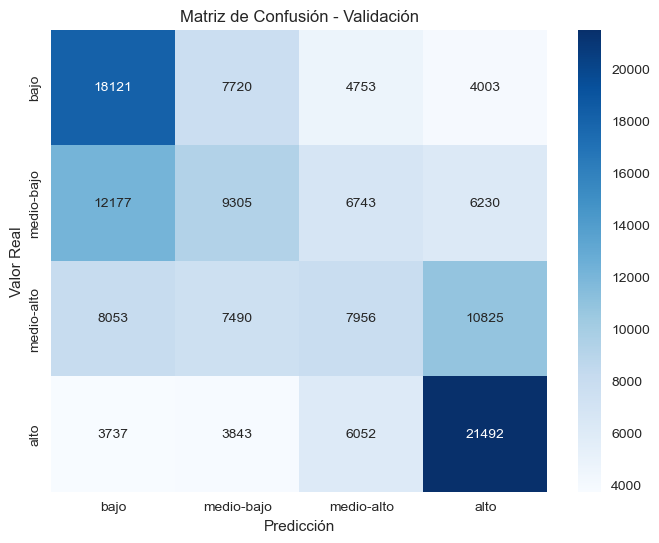

In [ ]:
# Entrenamiento del modelo Gradient Boosting
model = GradientBoostingClassifier(random_state=42)

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print(f"Validación cruzada: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Entrenamiento en conjunto completo
model.fit(X_train_scaled, y_train)

# Evaluación en validación
y_val_pred = model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Evaluación en prueba
y_test_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Accuracy validación: {val_accuracy:.4f}")
print(f"Accuracy prueba: {test_accuracy:.4f}")

# Matriz de confusión
label_mapping = {1: 'bajo', 2: 'medio-bajo', 3: 'medio-alto', 4: 'alto'}
cm = confusion_matrix(y_val, y_val_pred)
target_names = [label_mapping[i] for i in sorted(label_mapping.keys())]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

### Entrenamiento y Validación del Modelo

Entrenamos un modelo Gradient Boosting Classifier, evaluamos su rendimiento mediante validación cruzada y medimos su accuracy en conjuntos de validación y prueba.

## Modelado y Evaluación

In [ ]:
# Modelo final con todos los datos
X_all_processed = X.copy()

# Codificación categórica para todos los datos
if categorical_cols:
    final_label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_all_processed[col] = le.fit_transform(X_all_processed[col].astype(str))
        final_label_encoders[col] = le

# Escalado completo
X_all_scaled = scaler.fit_transform(X_all_processed)

# Entrenamiento final
final_model = GradientBoostingClassifier(random_state=42)
final_model.fit(X_all_scaled, y)

# Importancia de características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"Modelo final entrenado con {X.shape[0]:,} muestras")
print(f"5 características más importantes:")
print(feature_importance.head().to_string(index=False))

Modelo final entrenado con 692,500 muestras
5 características más importantes:
                       feature  importance
ESTU_VALORMATRICULAUNIVERSIDAD    0.444863
           FAMI_EDUCACIONMADRE    0.114690
        ESTU_PRGM_DEPARTAMENTO    0.049482
           FAMI_EDUCACIONPADRE    0.048024
                        coef_1    0.040288


### Modelo Final con Todos los Datos

Entrenamos el modelo final utilizando todo el dataset disponible para maximizar el aprendizaje, y analizamos la importancia de las características.

In [ ]:
# Preprocesamiento de datos de prueba
df_test_processed = df_test.copy()

# Mismas transformaciones que en entrenamiento
for col in columns_to_fill:
    if col in df_test_processed.columns:
        df_test_processed[col] = df_test_processed[col].fillna("no info")

# Normalizar programas académicos
if 'ESTU_PRGM_ACADEMICO' in df_test_processed.columns:
    df_test_processed['ESTU_PRGM_ACADEMICO_ORIGINAL'] = df_test_processed['ESTU_PRGM_ACADEMICO'].copy()
    df_test_processed['ESTU_PRGM_ACADEMICO'] = df_test_processed['ESTU_PRGM_ACADEMICO'].apply(
        lambda x: ud.unidecode(str(x).lower())
    )
    # Agrupar usando los mismos programas principales
    condition = ~df_test_processed['ESTU_PRGM_ACADEMICO'].isin(main_programs)
    df_test_processed.loc[condition, 'ESTU_PRGM_ACADEMICO'] = "otros"

# One-hot encoding para programas (usar mismas categorías)
if 'ESTU_PRGM_ACADEMICO' in df_test_processed.columns:
    all_programs = list(main_programs) + ['otros']
    for program in all_programs:
        df_test_processed[f'prgm_{program}'] = (df_test_processed['ESTU_PRGM_ACADEMICO'] == program).astype(int)

# Codificación ordinal (usar mismas categorías)
ordinal_cols_test = [col for col in ordinal_categories.keys() if col in df_test_processed.columns and col != 'RENDIMIENTO_GLOBAL']
if ordinal_cols_test:
    for col in ordinal_cols_test:
        value_to_num = {val: idx for idx, val in enumerate(ordinal_categories[col])}
        df_test_processed[col] = df_test_processed[col].map(value_to_num).fillna(0)

# One-hot encoding para variables binarias
for col in binary_vars:
    if col in df_test_processed.columns:
        df_test_processed[col] = df_test_processed[col].fillna("no info")
        categories = ['No', 'Si', 'no info'] if col != 'ESTU_PRIVADO_LIBERTAD' else ['N', 'S']
        for cat in categories:
            df_test_processed[f'{col}_{cat}'] = (df_test_processed[col] == cat).astype(int)
        df_test_processed.drop(col, axis=1, inplace=True)

# Preparar características finales
columns_to_drop_test = ['ESTU_CONSECUTIVO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_ACADEMICO_ORIGINAL']
columns_to_drop_test = [col for col in columns_to_drop_test if col in df_test_processed.columns]
X_test_kaggle = df_test_processed.drop(columns=columns_to_drop_test)

# Alinear columnas con entrenamiento
missing_cols = set(X.columns) - set(X_test_kaggle.columns)
extra_cols = set(X_test_kaggle.columns) - set(X.columns)

for col in missing_cols:
    X_test_kaggle[col] = 0
for col in extra_cols:
    if col in X_test_kaggle.columns:
        X_test_kaggle.drop(col, axis=1, inplace=True)

X_test_kaggle = X_test_kaggle[X.columns]

# Codificación categórica final
if categorical_cols:
    for col in categorical_cols:
        if col in X_test_kaggle.columns and col in final_label_encoders:
            try:
                unique_values = X_test_kaggle[col].unique()
                known_values = final_label_encoders[col].classes_
                unknown_mask = ~X_test_kaggle[col].isin(known_values)
                if unknown_mask.any():
                    X_test_kaggle.loc[unknown_mask, col] = known_values[0]
                X_test_kaggle[col] = final_label_encoders[col].transform(X_test_kaggle[col].astype(str))
            except:
                le_temp = LabelEncoder()
                X_test_kaggle[col] = le_temp.fit_transform(X_test_kaggle[col].astype(str))

# Escalado final
X_test_kaggle_scaled = scaler.transform(X_test_kaggle)

print(f"Datos de prueba procesados: {X_test_kaggle_scaled.shape}")
print(f"Alineación correcta: {X_test_kaggle_scaled.shape[1] == X_all_scaled.shape[1]}")

Datos de prueba procesados: (296786, 51)
Alineación correcta: True


### Preprocesamiento de Datos de Prueba

Aplicamos exactamente las mismas transformaciones de preprocesamiento a los datos de prueba, asegurando que sea consistente con el conjunto de entrenamiento.

## Predicciones y Submission

In [ ]:
# Generación de predicciones para Kaggle
test_predictions = final_model.predict(X_test_kaggle_scaled)

# Convertir a etiquetas de texto
label_mapping_inv = {1: 'bajo', 2: 'medio-bajo', 3: 'medio-alto', 4: 'alto'}
prediction_labels = [label_mapping_inv[pred] for pred in test_predictions]

# Distribución de predicciones
pred_counts = pd.Series(prediction_labels).value_counts()
print("Distribución de predicciones:")
for label, count in pred_counts.items():
    percentage = (count / len(prediction_labels)) * 100
    print(f"  {label}: {count:,} ({percentage:.1f}%)")

# Crear archivo de submission
if 'ID' in df_test.columns:
    submission = pd.DataFrame({
        'ID': df_test['ID'],
        'RENDIMIENTO_GLOBAL': prediction_labels
    })
elif 'ESTU_CONSECUTIVO' in df_test.columns:
    submission = pd.DataFrame({
        'ID': df_test['ESTU_CONSECUTIVO'],
        'RENDIMIENTO_GLOBAL': prediction_labels
    })
else:
    submission = pd.DataFrame({
        'ID': range(1, len(prediction_labels) + 1),
        'RENDIMIENTO_GLOBAL': prediction_labels
    })

# Guardar archivo
submission_filename = 'submission.csv'
submission.to_csv(submission_filename, index=False)

print(f"\nArchivo guardado: {submission_filename}")
print(f"Predicciones totales: {len(submission):,}")
print(f"Columnas: {list(submission.columns)}")
print("\nPrimeras 10 predicciones:")
print(submission.head(10).to_string(index=False))

Distribución de predicciones:
  bajo: 92,754 (31.3%)
  alto: 91,474 (30.8%)
  medio-bajo: 59,764 (20.1%)
  medio-alto: 52,794 (17.8%)

Archivo guardado: submission.csv
Predicciones totales: 296,786
Columnas: ['ID', 'RENDIMIENTO_GLOBAL']

Primeras 10 predicciones:
    ID RENDIMIENTO_GLOBAL
550236               alto
 98545         medio-alto
499179         medio-alto
782980               bajo
785185               bajo
 58495         medio-bajo
705444               alto
557548               alto
519909         medio-bajo
832058               alto


### Generación de Predicciones

Generamos las predicciones finales para el conjunto de prueba y creamos el archivo de submission

In [ ]:
try:
    !kaggle competitions submit -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia -f submission.csv -m "Modelo solución final - Gradient Boosting"
except:
    print("Error al enviar a Kaggle - verificar configuración")

# Verificar submissions
try:
    !kaggle competitions submissions -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia
except:
    print("No se pudieron obtener submissions")

# Resumen final
print("\n" + "="*50)
print("RESUMEN DEL MODELO SOLUCIÓN")
print("="*50)
print(f"Datos entrenamiento: {df_train.shape}")
print(f"Datos prueba: {df_test.shape}")
print(f"Características finales: {X.shape[1]}")
print(f"Modelo: Gradient Boosting Classifier")
print(f"Accuracy validación: {val_accuracy:.4f}")
print(f"Accuracy prueba: {test_accuracy:.4f}")
print(f"Validación cruzada: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Archivo generado: {submission_filename}")
print(f"Predicciones: {len(submission):,}")
print("="*50)

Successfully submitted to UDEA/ai4eng 20251 - Pruebas Saber Pro Colombia



  0%|          | 0.00/4.29M [00:00<?, ?B/s]
  0%|          | 8.00k/4.29M [00:00<03:01, 24.7kB/s]
  5%|5         | 232k/4.29M [00:00<00:06, 707kB/s]  
 12%|#2        | 536k/4.29M [00:00<00:02, 1.40MB/s]
 17%|#6        | 744k/4.29M [00:01<00:10, 344kB/s] 
 20%|#9        | 872k/4.29M [00:02<00:08, 405kB/s]
 23%|##3       | 1.01M/4.29M [00:02<00:06, 524kB/s]
 26%|##6       | 1.13M/4.29M [00:02<00:05, 605kB/s]
 29%|##9       | 1.25M/4.29M [00:02<00:04, 684kB/s]
 32%|###1      | 1.37M/4.29M [00:02<00:04, 688kB/s]
 35%|###4      | 1.48M/4.29M [00:02<00:03, 752kB/s]
 37%|###7      | 1.59M/4.29M [00:02<00:03, 786kB/s]
 40%|###9      | 1.70M/4.29M [00:02<00:03, 812kB/s]
 42%|####1     | 1.79M/4.29M [00:03<00:03, 807kB/s]
 44%|####3     | 1.88M/4.29M [00:03<00:03, 788kB/s]
 46%|####5     | 1.97M/4.29M [00:03<00:03, 799kB/s]
 48%|####7     | 2.05M/4.29M [00:03<00:02, 795kB/s]
 50%|#####     | 2.16M/4.29M [00:03<00:02, 883kB/s]
 54%|#####3    | 2.30M/4.29M [00:03<00:02, 1.01MB/s]
 57%|#####6    | 

fileName           date                        description                                            status                     publicScore  privateScore  
-----------------  --------------------------  -----------------------------------------------------  -------------------------  -----------  ------------  
submission.csv     2025-07-04 02:33:08.313000  Modelo solución final - Gradient Boosting              SubmissionStatus.PENDING                              
submission.csv     2025-07-04 00:02:57.940000  Preprocesado 3                                         SubmissionStatus.COMPLETE  0.30879                    
submission.csv     2025-07-03 23:55:29.800000  05 modelo con feature engineering y Gradient Boosting  SubmissionStatus.COMPLETE  0.25804                    
submission.csv     2025-07-03 21:57:23.173000  05 modelo con feature engineering y Gradient Boosting  SubmissionStatus.COMPLETE  0.27041                    
submission.csv     2025-07-03 18:38:55.810000  Preprocesad

In [ ]:
!kaggle competitions submissions -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

fileName           date                        description                                            status                     publicScore  privateScore  
-----------------  --------------------------  -----------------------------------------------------  -------------------------  -----------  ------------  
submission.csv     2025-07-04 02:33:08.313000  Modelo solución final - Gradient Boosting              SubmissionStatus.COMPLETE  0.41118                    
submission.csv     2025-07-04 00:02:57.940000  Preprocesado 3                                         SubmissionStatus.COMPLETE  0.30879                    
submission.csv     2025-07-03 23:55:29.800000  05 modelo con feature engineering y Gradient Boosting  SubmissionStatus.COMPLETE  0.25804                    
submission.csv     2025-07-03 21:57:23.173000  05 modelo con feature engineering y Gradient Boosting  SubmissionStatus.COMPLETE  0.27041                    
submission.csv     2025-07-03 18:38:55.810000  Preprocesad